# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette()
plt.rc('figure', figsize=(6.0, 4.0))

In [3]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
def plot_callback(func,p=20):
    def plot_epoch_end(epoch,logs):
        if epoch == 0 or (epoch+1) % p == 0:
            plt.clf(); func(); plt.title('epoch %d' % (epoch+1))
            display.clear_output(wait=True); display.display(plt.gcf())
    def clear(*args):
        plt.clf()
    return LambdaCallback(on_epoch_end=plot_epoch_end,on_train_end=clear)

In [5]:
def plot_loss_acc(hist):
    plt.figure(figsize=(12,3));
    if len(hist.params['metrics']) == 2:
        plt.subplot(121); plt.semilogy(hist.epoch,hist.history['loss'])
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(['train'],loc='upper right')
        plt.subplot(122); plt.plot(hist.epoch,hist.history['acc']);
        plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(['train'],loc='lower right');
    else:
        plt.subplot(121); plt.semilogy(hist.epoch,hist.history['loss'], hist.epoch,hist.history['val_loss']);
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(['train','test'],loc='upper right')
        plt.subplot(122); plt.plot(hist.epoch,hist.history['acc'], hist.epoch,hist.history['val_acc'])
        plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(['train','test'],loc='lower right');    

---

Adapted from http://blog.fastforwardlabs.com/2016/02/24/hello-world-in-keras-or-scikit-learn-versus.html

---

# Dataset

[Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set)

In [6]:
iris = sns.load_dataset("iris")
iris.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,species
105,7.6,3.0,6.6,2.1,virginica
104,6.5,3.0,5.8,2.2,virginica
57,4.9,2.4,3.3,1.0,versicolor
76,6.8,2.8,4.8,1.4,versicolor
101,5.8,2.7,5.1,1.9,virginica
120,6.9,3.2,5.7,2.3,virginica
113,5.7,2.5,5.0,2.0,virginica
61,5.9,3.0,4.2,1.5,versicolor
54,6.5,2.8,4.6,1.5,versicolor
82,5.8,2.7,3.9,1.2,versicolor


Image from https://commons.wikimedia.org/wiki/File:Petal-sepal.jpg
![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Petal-sepal.jpg/451px-Petal-sepal.jpg)

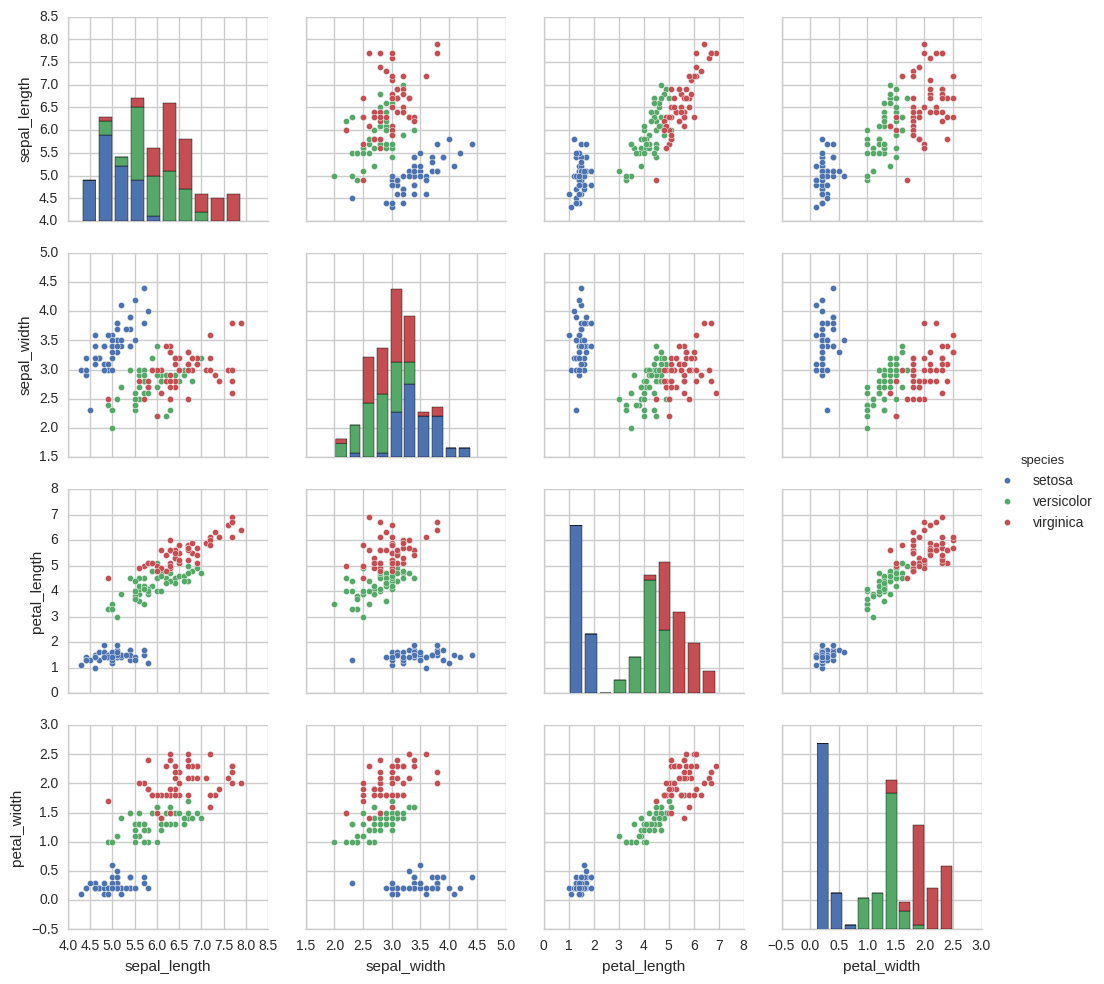

In [7]:
sns.pairplot(iris, hue='species');

## Label Encoding

In [8]:
def label_encode(arr):
    uniques, ids = np.unique(arr, return_inverse=True)
    return ids

In [9]:
classes = ('setosa', 'versicolor', 'virginica')
labels  = label_encode(classes)
for i,c in enumerate(classes):
    print '%10s → %d' % (c, labels[i] )

    setosa → 0
versicolor → 1
 virginica → 2


In [10]:
def onehot_encode(arr):
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

In [11]:
classes = ('setosa', 'versicolor', 'virginica')
onehot = onehot_encode(classes)
for i,c in enumerate(classes):
    print '%10s → [%d,%d,%d]' % (c, onehot[i,0], onehot[i,1], onehot[i,2] )

    setosa → [1,0,0]
versicolor → [0,1,0]
 virginica → [0,0,1]


# Multiclass Classification

## Data subset (1 feature only)

In [12]:
data = iris
feature_name = 'petal_length'
data = data[[feature_name,'species']]

In [13]:
X    = data.values[:,0]
y    = label_encode(data.values[:,1])
y_oh = onehot_encode(data.values[:,1])
N    = len(y)

## Plotting

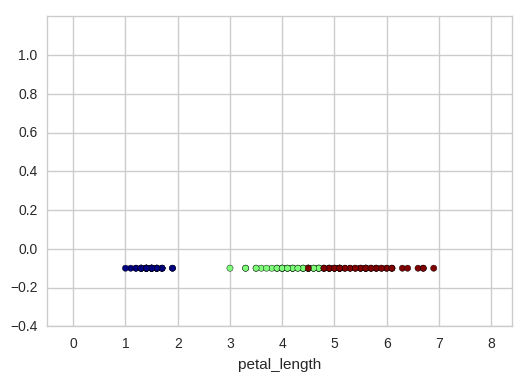

In [14]:
R = np.linspace(X.min()-1,X.max()+1,100)
Xp = np.zeros(X.shape[0])-.1
Rp = np.zeros(R.shape[0])-.2
def plot_all(model=None):
    plt.scatter(X, Xp, c=y, cmap='jet');
    plt.xlabel(feature_name)
    if model is not None:
        prob = model.predict(R)
        yhat = np.argmax(prob,axis=1)
        plt.scatter(R, Rp, c=yhat, cmap='jet');
        plt.plot(R,prob)
        leg = plt.legend(map(lambda s:'p("%s")'%s,classes),loc='upper center',frameon=False,ncol=3)
    plt.xlim(X.min()-1.5,X.max()+1.5)
    plt.ylim(-.4,1.2)
plot_all()

## Model (Logistic Regression)

- https://en.wikipedia.org/wiki/Multinomial_logistic_regression
- https://en.wikipedia.org/wiki/Softmax_function
- https://en.wikipedia.org/wiki/Cross_entropy

In [15]:
model = Sequential()
model.add(Dense(16, input_shape=(1,)))
model.add(Activation('tanh'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


### Softmax

Converts arbitrary "scores" to normalized probabilities:
$
\large
\sigma(\mathbf{z})_i = \frac{\exp(z_i)}{\sum_j \exp(z_j)}
$

Example: for $\mathbf{z} = [0.451, -0.599, 0.006]$, we get
$\sigma(\mathbf{z}) = [ 0.50232021,  0.1757808 ,  0.32189899]$.

### Cross entropy

$H(p, q) = \operatorname{E}_p[-\log q] = H(p) + D_{\mathrm{KL}}(p \| q)$
defines then cross entropy for distributions $p$ and $q$, where
- $H(p)$ is the entropy of $p$, and
- $D_{\mathrm{KL}}(p \| q)$ is the Kullback–Leibler divergence of $q$ from $p$.

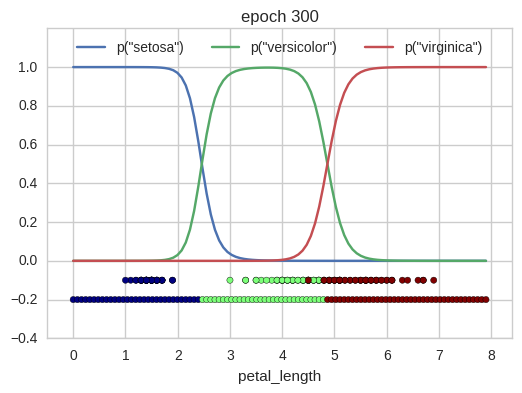

In [16]:
hist = model.fit(X,y_oh,batch_size=5,epochs=300,verbose=0,
                 callbacks=[plot_callback(lambda:plot_all(model))]);

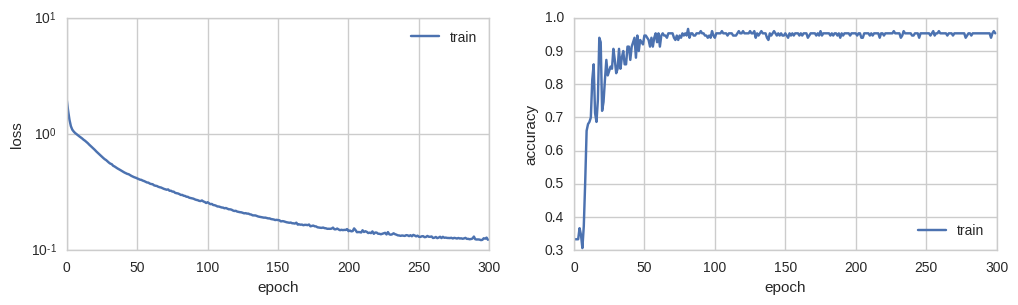

In [17]:
plot_loss_acc(hist)

## Full dataset (all 4 features)

Use all features and split dataset in train and test subsets:

In [18]:
N = iris.shape[0] # number of data points / table rows
data = iris.sample(N,replace=False) # shuffle data
X    = data.values[:,0:4]
y_oh = onehot_encode(data.values[:,4])

N_train = N/2 # random 50/50 train/test split
X_train, y_train = X[:N_train], y_oh[:N_train]
X_test,  y_test  = X[N_train:], y_oh[N_train:]

In [19]:
model = Sequential()
model.add(Dense(16, input_shape=(4,)))
model.add(Activation('tanh'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_4 (Activation)    (None, 3)                 0         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [20]:
hist = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=200, verbose=0, batch_size=5)

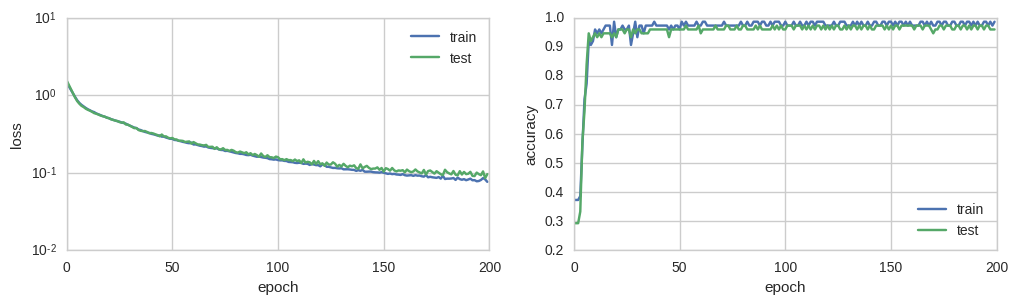

In [21]:
plot_loss_acc(hist)

In [22]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print 'train set: loss = %.5f, accuracy = %.5f' % (loss,accuracy)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print 'test  set: loss = %.5f, accuracy = %.5f' % (loss,accuracy)

train set: loss = 0.07572, accuracy = 0.98667
test  set: loss = 0.09608, accuracy = 0.96000


## Overfitting

In [23]:
N_train = 20 # only 20 of 150 samples for training, rest for testing
X_train, y_train = X[:N_train], y_oh[:N_train]
X_test,  y_test  = X[N_train:], y_oh[N_train:]

In [24]:
model = Sequential()
model.add(Dense(16, input_shape=(4,)))
model.add(Activation('tanh'))
model.add(Dense(16))
model.add(Activation('tanh'))
model.add(Dense(16))
model.add(Activation('tanh'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_7 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 51        
__________

In [25]:
hist = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=1000, verbose=0, batch_size=5)

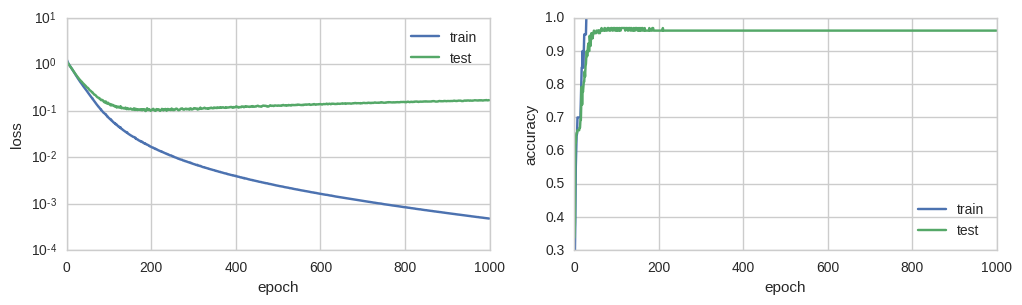

In [26]:
plot_loss_acc(hist)

In [27]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print 'train set: loss = %.5f, accuracy = %.5f' % (loss,accuracy)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print 'test  set: loss = %.5f, accuracy = %.5f' % (loss,accuracy)

train set: loss = 0.00048, accuracy = 1.00000
test  set: loss = 0.16897, accuracy = 0.96154
